In [93]:
import pandas as pd
from functools import reduce
from pprint import pprint

assets = ["DOGEUSDC", "SOLUSDC"]

# Load all dataframes and extract the time columns
time_columns = []
merged_dfs = []
for asset in assets:
    df = pd.read_csv(f"assets/{asset}.csv")
    df.iloc[:, 0] = df.iloc[:, 0].apply(lambda x: int(f"{x}000") if len(str(x)) == 13 else x)
    df['Asset'] = asset  # Add a column with the asset name

    merged_dfs.append(df)
    time_columns.append(set(df.iloc[:, 0]))

merged_df = pd.concat(merged_dfs, ignore_index=True)


# Find the minimum common set of times
common_times = reduce(lambda x, y: x & y, time_columns)
common_times = pd.to_datetime(list(common_times), unit='us')
# Group common_times into ranges with no gap greater than 5 minutes
common_times = common_times.sort_values()
ranges = []
start = common_times[0]
prev = common_times[0]

for current in common_times[1:]:
    if (current - prev).total_seconds() > 1800:  # 5 minutes in seconds
        ranges.append((start, prev))
        start = current
    prev = current

ranges.append((start, prev))  # Add the last range

# Convert ranges to a set of tuples
date_ranges = set(ranges)

for start, end in date_ranges:
    duration = end - start
    days = duration.days
    hours = duration.seconds // 3600
    num_half_hour_points = (end - start).total_seconds() // 1800
    
    print(f"{start} to {end}, duration: {days} days and {hours} hours ({int(num_half_hour_points)} windows)")

2025-02-01 00:30:00 to 2025-02-28 23:30:00, duration: 27 days and 23 hours (1342 windows)
2024-08-01 00:00:00 to 2025-01-31 23:30:00, duration: 183 days and 23 hours (8831 windows)
2024-03-07 08:00:00 to 2024-07-07 23:30:00, duration: 122 days and 15 hours (5887 windows)


In [94]:
from pandas import Timestamp

training = (Timestamp('2024-08-01 00:00:00'), Timestamp('2025-01-31 23:30:00'))
testing = (Timestamp('2025-02-01 00:30:00'), Timestamp('2025-02-28 23:30:00'))

In [95]:
def get_price_by_timestamp(timestamp):
    open_prices = {}
    timestamp_us = int(timestamp.timestamp() * 1e6)
    for asset in assets:
        open_series = merged_df[(merged_df['Asset'] == asset) & (merged_df['Open time'] == timestamp_us)]['Open']
        open_prices[asset] = open_series.iloc[0] if not open_series.empty else None
    return open_prices

def generate_30_min_ranges(start, end):
    return pd.date_range(start=start, end=end, freq='30T', inclusive='both').tolist()

In [96]:
get_price_by_timestamp(Timestamp('2025-02-01 00:30:00'))

{'DOGEUSDC': np.float64(0.3281), 'SOLUSDC': np.float64(231.24)}

In [97]:
class Portfolio:
    def __init__(self, weights, start):
        self.weights = weights
        self.prices = start

    def update(self, current):
        self.prices = current
        return self.weights
    
start = list(get_price_by_timestamp(testing[0]).values())
A = Portfolio([0.8, 0.2], start)

In [98]:
def test_portfolio(portfolio):
    returns = [0]

    timestamps = generate_30_min_ranges(*testing)
    windows = zip(timestamps[:-1], timestamps[1:])

    prior_prices = list(get_price_by_timestamp(testing[0]).values())
    prior_weights = portfolio.weights
    for window in windows:
        post_prices = list(get_price_by_timestamp(window[1]).values())
        post_weights = portfolio.update(post_prices)

        returns.append(returns[-1] + sum((post_prices[i] - prior_prices[i]) / prior_prices[i] * prior_weights[i] for i, asset in enumerate(assets)))
        prior_prices = post_prices
        prior_weights = post_weights

    return returns

        

C:\Users\ic2594\AppData\Local\Temp\ipykernel_13396\1208593353.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  return pd.date_range(start=start, end=end, freq='30T', inclusive='both').tolist()


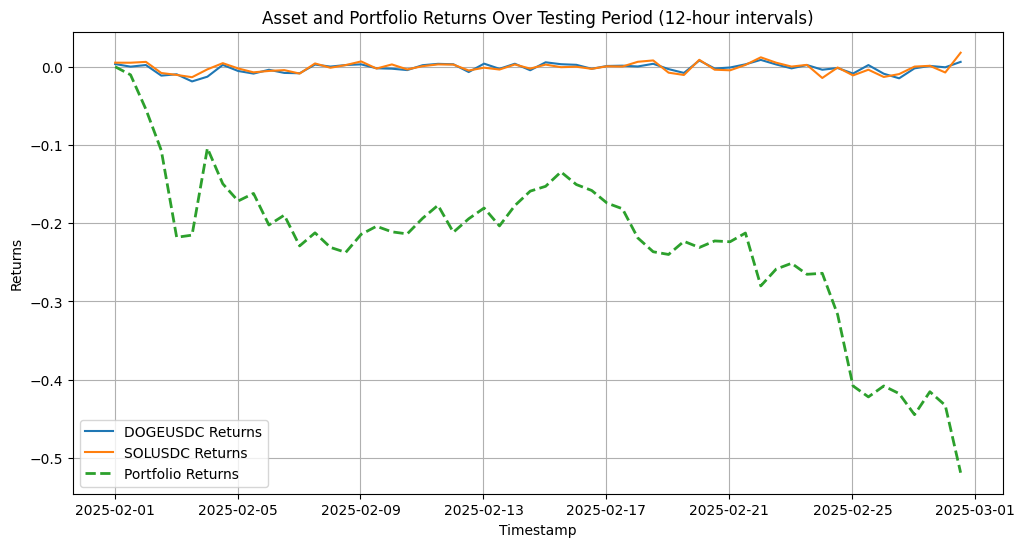

In [99]:
import matplotlib.pyplot as plt

# Generate timestamps for the testing period
timestamps = generate_30_min_ranges(*testing)

# Initialize lists to store returns
asset_returns = {asset: [] for asset in assets}
portfolio_returns = test_portfolio(A)

# Calculate asset returns
prior_prices = list(get_price_by_timestamp(testing[0]).values())
for i in range(1, len(timestamps)):
    current_prices = list(get_price_by_timestamp(timestamps[i]).values())
    for j, asset in enumerate(assets):
        if prior_prices[j] is not None and current_prices[j] is not None:
            asset_return = (current_prices[j] - prior_prices[j]) / prior_prices[j]
            asset_returns[asset].append(asset_return)
        else:
            asset_returns[asset].append(0)  # Handle missing data
    prior_prices = current_prices

# Plot the returns
plt.figure(figsize=(12, 6))

# Plot asset returns
# Downsample timestamps and returns to every 12 hours
downsampled_timestamps = timestamps[::24]  # 24 intervals of 30 minutes = 12 hours
downsampled_asset_returns = {asset: returns[::24] for asset, returns in asset_returns.items()}
downsampled_portfolio_returns = portfolio_returns[::24]

# Plot asset returns
for asset, returns in downsampled_asset_returns.items():
    plt.plot(downsampled_timestamps, returns, label=f"{asset} Returns")

# Plot portfolio returns
plt.plot(downsampled_timestamps, downsampled_portfolio_returns, label="Portfolio Returns", linewidth=2, linestyle="--")

plt.xlabel("Timestamp")
plt.ylabel("Returns")
plt.title("Asset and Portfolio Returns Over Testing Period (12-hour intervals)")
plt.legend()
plt.grid()
plt.show()